In [1]:
from matplotlib.mlab import griddata
import matplotlib.pyplot as plt

import time, os
from collections import defaultdict

import numpy as np
from numpy import linspace
from numpy import meshgrid
from numpy.random import uniform, seed

from mpl_toolkits.basemap import Basemap, shiftgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

title_sz = 27
axis_sz = 22
tick_sz = 21

from matplotlib.ticker import MaxNLocator
from matplotlib import cm, rcParams
rcParams.update({'font.size': tick_sz-4}) # Increase font-size
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib import gridspec

import pylab as pl

from itertools import islice
import sys, pickle, time, copy, re

from chem_ocean import Build_Map as bm

import sqlalchemy

In [2]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    url  = 'postgresql://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con, reflect=True)

    return con, meta, url

In [3]:
def make_section(ax, _colors, _x, _y, _latLon_params, model_raw):
    if model_raw == 'model':
        for im in range(len(_x)):
            ax.plot(_x[im], _y[im], c = _colors[im], marker = 'o', markersize=15, alpha = .1)

    ax.invert_yaxis()

    axin = inset_axes(ax, width="35%", height="35%", loc=4)
    inmap = Basemap(projection='ortho', lon_0=np.mean(_latLon_params[0]), lat_0=0,
        ax=axin, anchor='NE')
    inmap.fillcontinents()
    inmap.drawcoastlines(color='k')
    inmap.plot(_latLon_params[0], _latLon_params[1], '-k', linewidth=2 , latlon=True)  
    return ax


In [28]:
#This is a special version to accomodate a z_var
def return_from_psql(query, cols, _in_var_names, _x_var, _y_var, **kwargs):
    conn, meta, url = connect('jlanders', '', 'odv_app_dev', host='localhost', port=5432)
    result = conn.execute(query)
    print(query)
    
    cluster_d = defaultdict(list)
    for row in result:
        for ik, col in enumerate(cols):
            cluster_d[col].append(row[ik])
    _x = np.asarray(cluster_d[_x_var])
    _y = np.asarray(cluster_d[_y_var])
    _d = np.asarray(cluster_d['depth'])
    
    _feat_data = np.zeros((len(cluster_d['station']), len(_in_var_names))) 
    for ik, name in enumerate(_in_var_names):
        _feat_data[:, ik] = np.asarray(cluster_d[name])

    mask = np.all(np.isnan(_feat_data), axis=1)
    _x = _x[~mask]
    _y = _y[~mask]
    _d = _d[~mask]
    _feat_data = _feat_data[~mask]
    _feat_data = [_feat_data[ik][0] for ik in range(len(_feat_data))]
    
    return cluster_d, _feat_data, _x, _y, _d



In [29]:
def get_plan(lat_bounds, lon_bounds, _var_names, depth):
    sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
    cols = ', '.join(sum_names)
    query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{} and depth={};".format(str(lat_bounds[0]), str(lat_bounds[1]), str(lon_bounds[0]), str(lon_bounds[1]), str(depth))
    
    _x_var = 'longitude'
    _y_var = 'latitude'

    cluster_d, _feat_data, _x, _y, _d = return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
    print(cluster_d.keys())
    _basemap = True
    _latLon_params = None
    
    return _x, _y, _d, _feat_data, _basemap, _x_var.title()+' (deg)', _y_var.title()+' (deg)', _latLon_params
    
def get_section(traj_type, line, limits, _var_names):
    sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
    cols = ', '.join(sum_names)
    traj_bounds = (line-1.5, line+1.5)
    
    if traj_type == 'EW_section':
        query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(traj_bounds[0]), str(traj_bounds[1]), str(limits[0]), str(limits[1]))
        
        _x_var = 'longitude'
        _y_var = 'depth'
        
        cluster_d, _feat_data, _x, _y, _d = return_from_psql(query, sum_names, _var_names, _x_var, _y_var)

        _yLab = 'Depth (m))'  
        _xLab = 'Longitude (deg) along '+ r'%s $^\circ$' % abs(line)+ ['S' if lat<0 else 'N' for lat in [line]][0]
        _basemap = False
        _latLon_params = (limits, (line, line))
        
    if traj_type == 'NS_section':
        query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(limits[0]), str(limits[1]), str(traj_bounds[0]), str(traj_bounds[1]))
        
        _x_var = 'latitude'
        _y_var = 'depth'
        
        cluster_d, _feat_data, _x, _y, _d = return_from_psql(query, sum_names, _var_names, _x_var, _y_var)

        _yLab = 'Depth (m)'  
        _xLab = 'Latitude (deg) along '+ r'%s $^\circ$' % abs(line)+ ['W' if lon<0 else 'E' for lon in [line]][0]
        _basemap = False
        _latLon_params = ((line, line), limits)

    return _x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params

    
def get_column(lat_bounds, lon_bounds, _var_names):
    sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
    cols = ', '.join(sum_names)
    query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(lat_bounds[0]), str(lat_bounds[1]), str(lon_bounds[0]), str(lon_bounds[1]))
    
    _x_var = 'longitude'
    _y_var = 'latitude'

    cluster_d, _feat_data, _x, _y, _d = return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
    print(cluster_d.keys())
    _basemap = True
    _latLon_params = None
    
    return _x, _y, _d, _feat_data, _basemap, _x_var.title()+' (deg)', _y_var.title()+' (deg)', _latLon_params
    

In [33]:
def plotRaw(minLat, maxLat, minLon, maxLon, _in_var_names, _sliceType, **kwargs):
    units_dict = {'temperature': '$^\circ$C', 'oxygen': 'ml/l', 'aou': 'ml/l', 'longitude': '$^\circ$E', 'salinity': '(psu)', 'nitrate': '$\mu$mol/l', 'depth': 'm', 'phosphate': '$\mu$mol/l', 'latitude': '$^\circ$N', 'oxygen_saturation': '%'}

    if _sliceType == 'column':
        _x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_column([minLat, maxLat], [minLon, maxLon], _in_var_names)
    
    else:
        if _sliceType == 'plan':
            _x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_plan([minLat, maxLat], [minLon, maxLon], _in_var_names, kwargs['depth'])

            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7), facecolor='w')
            _basemap, fig, ax = bm.build_map('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax, 111, 'lb')
            x_coord,y_coord = _basemap(_x, _y)
            cbar_pad = .22
            plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)
            ylabpad = 35
            xlabpad = 25
            plt.tight_layout(pad=0.4, w_pad=1., h_pad=1.0)

        else:
            if _sliceType == 'NS_section': 
                _x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_section('NS_section', minLon, [minLat, maxLat], _in_var_names)
            elif _sliceType == 'EW_section': 
                _x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_section('EW_section', minLat, [minLon, maxLon], _in_var_names)

            x_dim = np.floor((max(_x)-min(_x))/140 * 12)
            y_dim = np.floor((max(_y)-min(_y))/5500 * 7)
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(x_dim, y_dim), facecolor='w')
            x_coord = _x
            y_coord = _y
            ylabpad = 0
            xlabpad = 0

        # define grid.
        xi = np.linspace(min(x_coord), max(x_coord),300)
        yi = np.linspace(min(y_coord), max(y_coord),300)

        # grid the data.
        zi = griddata(x_coord,y_coord,_feat_data,xi,yi,interp='linear')

        # contour the gridded data, plotting dots at the nonuniform data points.
        CS = plt.contour(xi,yi,zi,10,linewidths=0.5,colors='k')
        CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.rainbow, 
                        vmax=abs(zi).max(), vmin=abs(zi).min())

        # label axes
        ax.set_ylabel(_yLab, fontsize=axis_sz-3, labelpad = ylabpad)
        ax.set_xlabel(_xLab, fontsize=axis_sz-3, labelpad = xlabpad)

        # reverse axis of y is depth
        if not _basemap:
            ax = make_section(plt.gca(), None, _x,_y, _latLon_params, 'raw')  
            cbar_pad = .22

        # create colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=cbar_pad)
        cbar = plt.colorbar(CS, cax=cax)
        cbar_label = _in_var_names[0] + ' (' + units_dict[_in_var_names[0]] + ')'
        cbar.ax.set_ylabel(cbar_label, fontsize=axis_sz) 

        # set tick size
        xtickNames = ax.get_xticklabels()
        ytickNames = ax.get_yticklabels()
        cbartickNames = cbar.ax.get_yticklabels()

        for names in [ytickNames, xtickNames, cbartickNames]:
            plt.setp(names, rotation=0, fontsize=tick_sz-4)

    # plt.show()
    return fig



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.
  # Remove the CWD from sys.path while we load stuff.


select station, longitude, latitude, depth, nitrate from woa13 where latitude> -70 AND latitude< 0 AND longitude>-33.5 and longitude<-30.5;


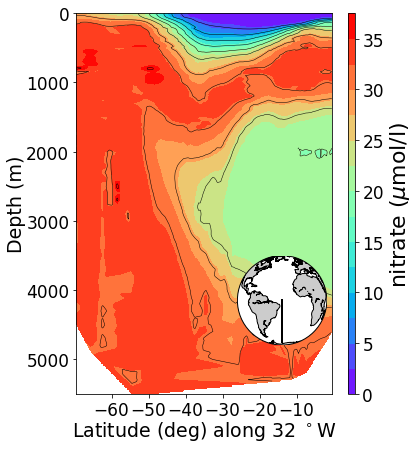

In [34]:
fig = plotRaw(-70, 0, -32, -32, ['nitrate'], 'NS_section')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.
  # Remove the CWD from sys.path while we load stuff.


select station, longitude, latitude, depth, nitrate from woa13 where latitude> -70 AND latitude< 60 AND longitude>-20 and longitude<0 and depth=2000;
dict_keys(['station', 'longitude', 'latitude', 'depth', 'nitrate'])
0.06007981300354004


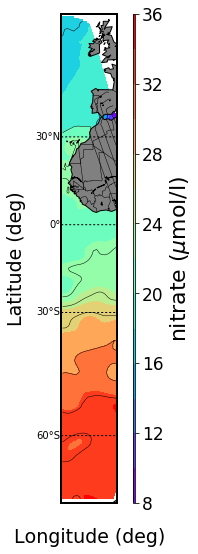

In [35]:
fig = plotRaw(-70, 60, -20, 0, ['nitrate'], 'plan', depth = 2000)